### import required libraries

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import joblib
import os
import math

### read the data file

In [137]:
data = pd.read_csv('Final_Merged.csv')
data.head()

,Unnamed: 0,Id,BIRTHDATE,DEATHDATE,FIRST,LAST,RACE,ETHNICITY,GENDER,CITY,STATE,COUNTY,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,age,SCORE,COUNT,WEIGHT,ADH,Life Span
0,0,00185faa-2760-4218-9bf5-db301acf8274,2003-11-18,0,Eusebio566,Wyman904,white,nonhispanic,M,Lynn,Massachusetts,Essex County,360851.05,9863.36,20,2,5,0.400000,-1,1
1,1,0042862c-9889-4a2e-b782-fac1e540ecb4,2009-11-26,0,Dewitt635,Feest103,white,nonhispanic,M,Boston,Massachusetts,Suffolk County,20006.08,1240.76,14,4,4,1.000000,1,1
2,2,0047123f-12e7-486c-82df-53b3a450e365,1960-01-20,0,Jordon466,Harber290,black,nonhispanic,M,Middleton,Massachusetts,Essex County,185715.36,7108.77,63,4,6,0.666667,1,1
3,3,010d4a3a-2316-45ed-ae15-16f01c611674,1998-05-31,0,Patrick786,Hettinger594,white,nonhispanic,M,Pittsfield,Massachusetts,Berkshire County,504727.10,3346.40,25,2,3,0.666667,1,1
4,4,0149d553-f571-4e99-867e-fcb9625d07c2,1979-06-21,0,Sophie40,Kessler503,white,hispanic,F,Northborough,Massachusetts,Worcester County,911327.42,6713.48,44,5,9,0.555556,-1,1


### feature extraction

#### selected important features that has good impact on adherence 

In [138]:
data=data.drop(["Unnamed: 0",'Id', 'BIRTHDATE','STATE','DEATHDATE','FIRST','LAST','SCORE','COUNT','WEIGHT'], axis = 1)

In [139]:
for feature in data.columns:
    print(feature)
    print(data[feature].dtypes)
    print(len(data[feature].unique()))

RACE
object
5
ETHNICITY
object
2
GENDER
object
2
CITY
object
235
COUNTY
object
14
HEALTHCARE_EXPENSES
float64
1152
HEALTHCARE_COVERAGE
float64
1059
age
int64
101
ADH
int64
2
Life Span
int64
2


In [140]:
def datatypescheck(df):
    numerical_feature= [feature for feature in df.columns if df[feature].dtypes != 'O']
    discrete_feature=[feature for feature in numerical_feature if df[feature].dtypes == 'int64' or df[feature].dtypes == 'int32']
    continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
    categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]
    print("Numerical Features Count {}".format(len(numerical_feature)))
    print("Discrete feature Count {}".format(len(discrete_feature)))
    print("Continuous feature Count {}".format(len(continuous_feature)))
    print("Categorical feature Count {}".format(len(categorical_feature)))
    print("Numerical features:",numerical_feature)
    print("discrete_features:",discrete_feature)
    print("continuous_features:",continuous_feature)
    print("categorical_features:",categorical_feature)
    return numerical_feature,discrete_feature,continuous_feature,categorical_feature

In [141]:
numerical_feature,discrete_feature,continuous_feature,categorical_feature=datatypescheck(data)

Numerical Features Count 5
Discrete feature Count 3
Continuous feature Count 2
Categorical feature Count 5
Numerical features: ['HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE', 'age', 'ADH', 'Life Span']
discrete_features: ['age', 'ADH', 'Life Span']
continuous_features: ['HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE']
categorical_features: ['RACE', 'ETHNICITY', 'GENDER', 'CITY', 'COUNTY']


### label encoded data

In [142]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

# Select categorical columns for label encoding
categorical_columns = ['RACE', 'ETHNICITY', 'GENDER', 'CITY', 'COUNTY']

# Use a loop to apply LabelEncoder to each categorical column
for col in categorical_columns:
    data[col] = labelencoder.fit_transform(data[col])
    
    # Displaying the mapping of original categories to encoded labels
    print(f"Mapping for {col}:")
    print(dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_))))


Mapping for RACE:
{'asian': 0, 'black': 1, 'native': 2, 'other': 3, 'white': 4}
Mapping for ETHNICITY:
{'hispanic': 0, 'nonhispanic': 1}
Mapping for GENDER:
{'F': 0, 'M': 1}
Mapping for CITY:
{'Abington': 0, 'Acton': 1, 'Acushnet': 2, 'Adams': 3, 'Agawam': 4, 'Amesbury': 5, 'Amherst': 6, 'Andover': 7, 'Arlington': 8, 'Ashburnham': 9, 'Ashland': 10, 'Athol': 11, 'Attleboro': 12, 'Auburn': 13, 'Avon': 14, 'Ayer': 15, 'Barnstable': 16, 'Belchertown': 17, 'Bellingham': 18, 'Belmont': 19, 'Bernardston': 20, 'Beverly': 21, 'Billerica': 22, 'Blackstone': 23, 'Boston': 24, 'Bourne': 25, 'Boxford': 26, 'Braintree': 27, 'Brewster': 28, 'Bridgewater': 29, 'Brockton': 30, 'Brookline': 31, 'Burlington': 32, 'Cambridge': 33, 'Canton': 34, 'Carlisle': 35, 'Carver': 36, 'Chatham': 37, 'Chelmsford': 38, 'Chelsea': 39, 'Cheshire': 40, 'Chester': 41, 'Chicopee': 42, 'Clinton': 43, 'Cohasset': 44, 'Concord': 45, 'Dalton': 46, 'Danvers': 47, 'Dartmouth': 48, 'Dedham': 49, 'Deerfield': 50, 'Dennis': 51, 'Do

In [143]:
numerical_feature,discrete_feature,continuous_feature,categorical_feature=datatypescheck(data)

Numerical Features Count 10
Discrete feature Count 8
Continuous feature Count 2
Categorical feature Count 0
Numerical features: ['RACE', 'ETHNICITY', 'GENDER', 'CITY', 'COUNTY', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE', 'age', 'ADH', 'Life Span']
discrete_features: ['RACE', 'ETHNICITY', 'GENDER', 'CITY', 'COUNTY', 'age', 'ADH', 'Life Span']
continuous_features: ['HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE']
categorical_features: []


In [144]:
data

,RACE,ETHNICITY,GENDER,CITY,COUNTY,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,age,ADH,Life Span
0,4,1,1,111,4,360851.05,9863.36,20,-1,1
1,4,1,1,24,12,20006.08,1240.76,14,1,1
2,1,1,1,128,4,185715.36,7108.77,63,1,1
3,4,1,1,159,1,504727.10,3346.40,25,1,1
4,4,0,0,148,13,911327.42,6713.48,44,-1,1
...,...,...,...,...,...,...,...,...,...,...
1147,4,1,1,53,10,548297.95,2920.64,24,1,1
1148,4,1,1,17,7,530003.98,3405.56,26,-1,1
1149,4,1,0,65,2,994509.38,16754.77,46,-1,1
1150,1,1,0,111,4,115095.69,7002.65,57,-1,-1


### checking and handling missing values

In [145]:
#Function to analyse missing values in the dataset
def missing_values(df):
    missing_results = round(df.isnull().sum()/len(df)*100,2)
    print(missing_results)
    print("Average null values in the dataset: %4.2f"%missing_results.mean()," %")

In [146]:
missing_values(data)

RACE                   0.0
ETHNICITY              0.0
GENDER                 0.0
CITY                   0.0
COUNTY                 0.0
HEALTHCARE_EXPENSES    0.0
HEALTHCARE_COVERAGE    0.0
age                    0.0
ADH                    0.0
Life Span              0.0
dtype: float64
Average null values in the dataset: 0.00  %


### remove duplicates

In [147]:
#remove duplicates
data.drop_duplicates(inplace=True)

### handling outliers

C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is 

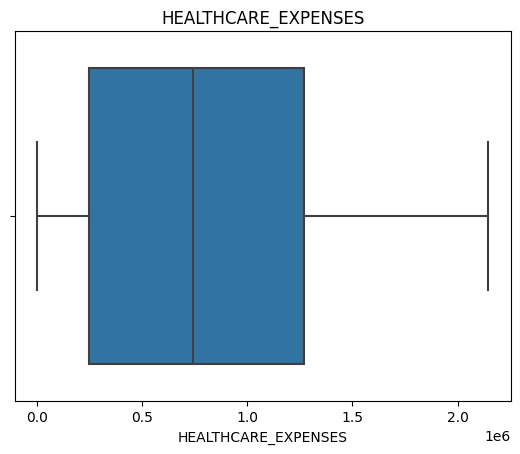

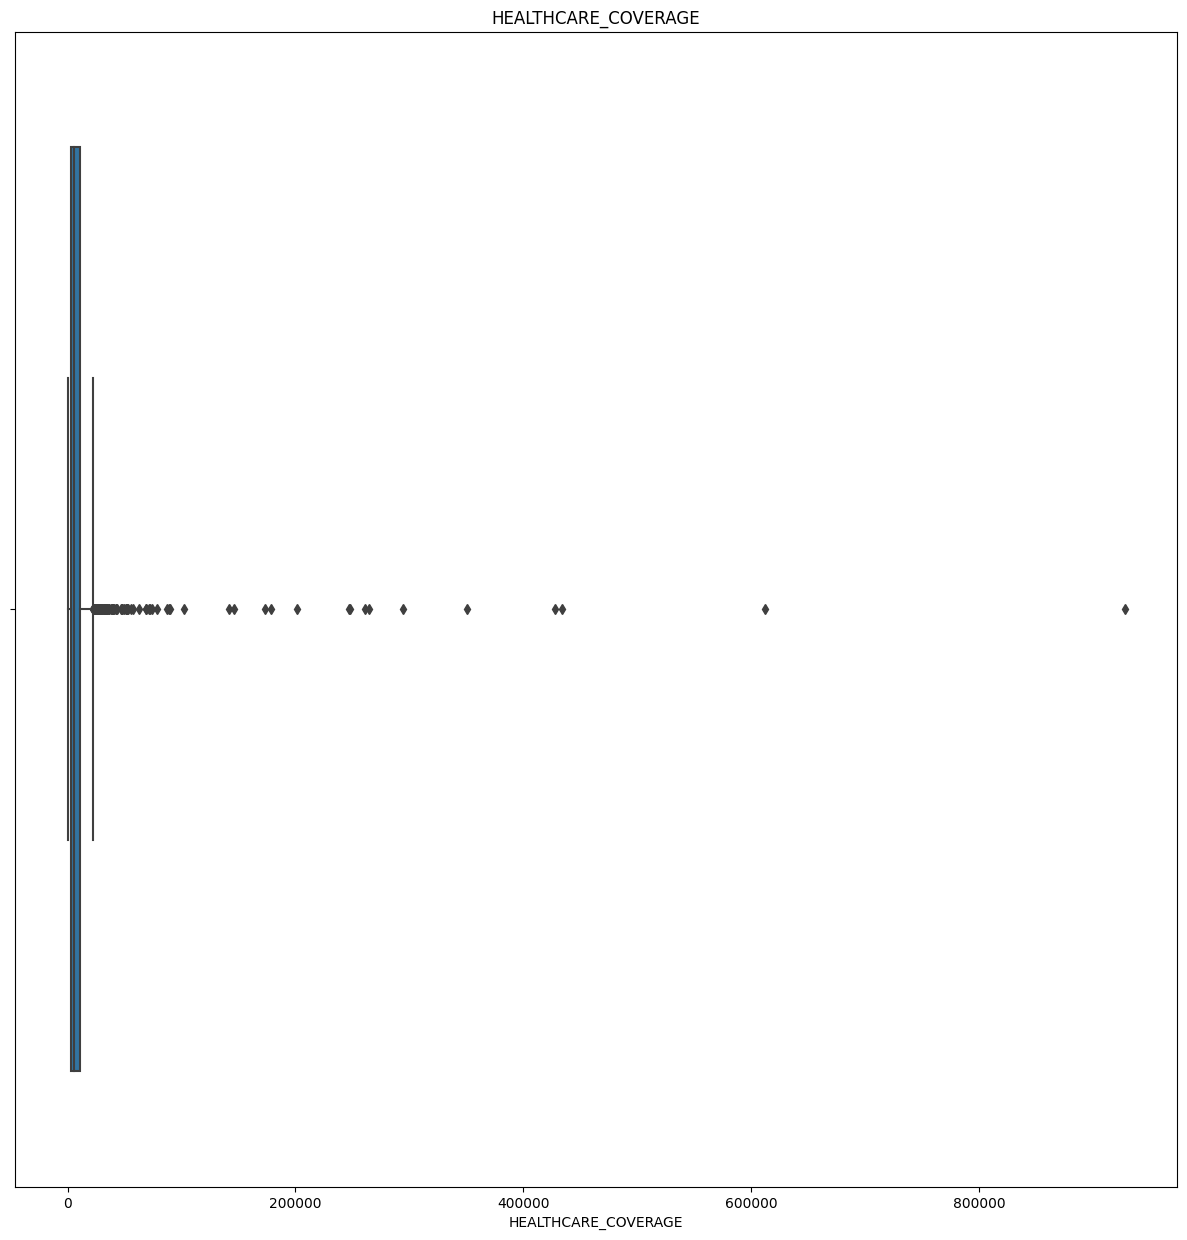

<Figure size 1500x1500 with 0 Axes>

In [148]:
for feature in continuous_feature:
    data1=data.copy()
    sns.boxplot(data1[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [149]:
def removeoutlier(df,variable):
    IQR=df[variable].quantile(0.75)-df[variable].quantile(0.25)
    lower_bridge=df[variable].quantile(0.25)-(IQR*1.5)
    upper_bridge=df[variable].quantile(0.75)+(IQR*1.5)
    print(lower_bridge, upper_bridge)
    df.loc[df[variable]>=upper_bridge,variable]=upper_bridge
    df.loc[df[variable]<=lower_bridge,variable]=lower_bridge

In [150]:
for feature in continuous_feature:
    print(feature)
    removeoutlier(data,feature)

HEALTHCARE_EXPENSES
-1281900.7774999999 2798956.7024999997
HEALTHCARE_COVERAGE
-8302.81 22251.83


C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is 

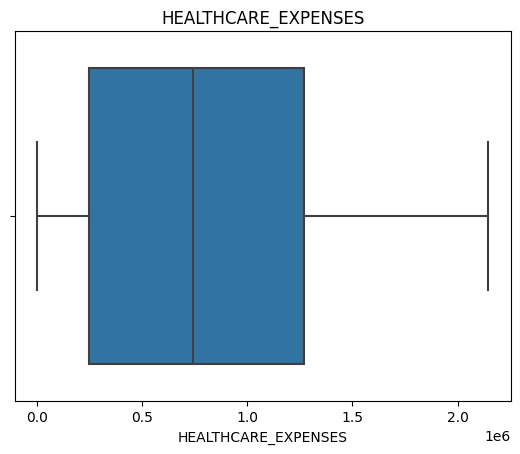

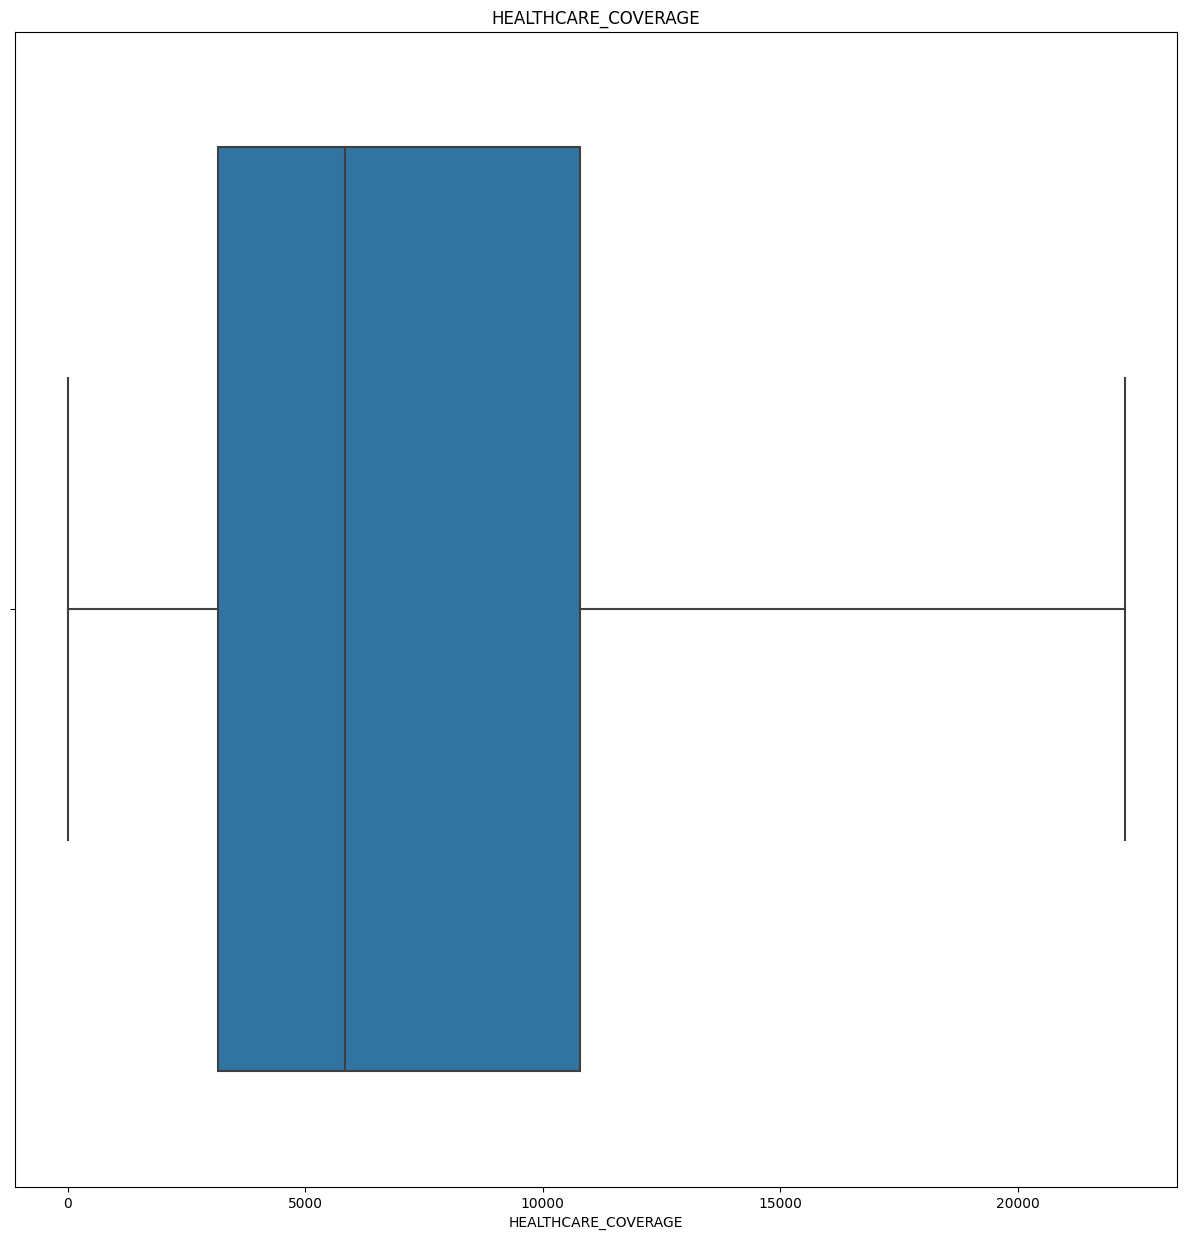

<Figure size 1500x1500 with 0 Axes>

In [151]:
for feature in continuous_feature:
    data1=data.copy()
    sns.boxplot(data1[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [152]:
# Specify the file path for the CSV file
csv_file_path = 'preprocesseddata.csv'

# Save the DataFrame to a CSV file
data.to_csv(csv_file_path, index=False)

### correlation Analysis

In [153]:
corrmat = data.corr()
print(corrmat)

                         RACE  ETHNICITY    GENDER      CITY    COUNTY  \
RACE                 1.000000   0.038207 -0.031056  0.071535 -0.080983   
ETHNICITY            0.038207   1.000000  0.000326  0.052888 -0.032967   
GENDER              -0.031056   0.000326  1.000000 -0.049186  0.015265   
CITY                 0.071535   0.052888 -0.049186  1.000000 -0.025022   
COUNTY              -0.080983  -0.032967  0.015265 -0.025022  1.000000   
HEALTHCARE_EXPENSES  0.015399   0.090289  0.013832  0.062252  0.002283   
HEALTHCARE_COVERAGE -0.053452   0.047171 -0.192755  0.027824 -0.061830   
age                 -0.073816   0.106148  0.042171  0.021079 -0.054786   
ADH                  0.065096  -0.040999 -0.069454 -0.031240  0.043277   
Life Span            0.034506  -0.053158 -0.102427  0.020012  0.064026   

                     HEALTHCARE_EXPENSES  HEALTHCARE_COVERAGE       age  \
RACE                            0.015399            -0.053452 -0.073816   
ETHNICITY                       0.0

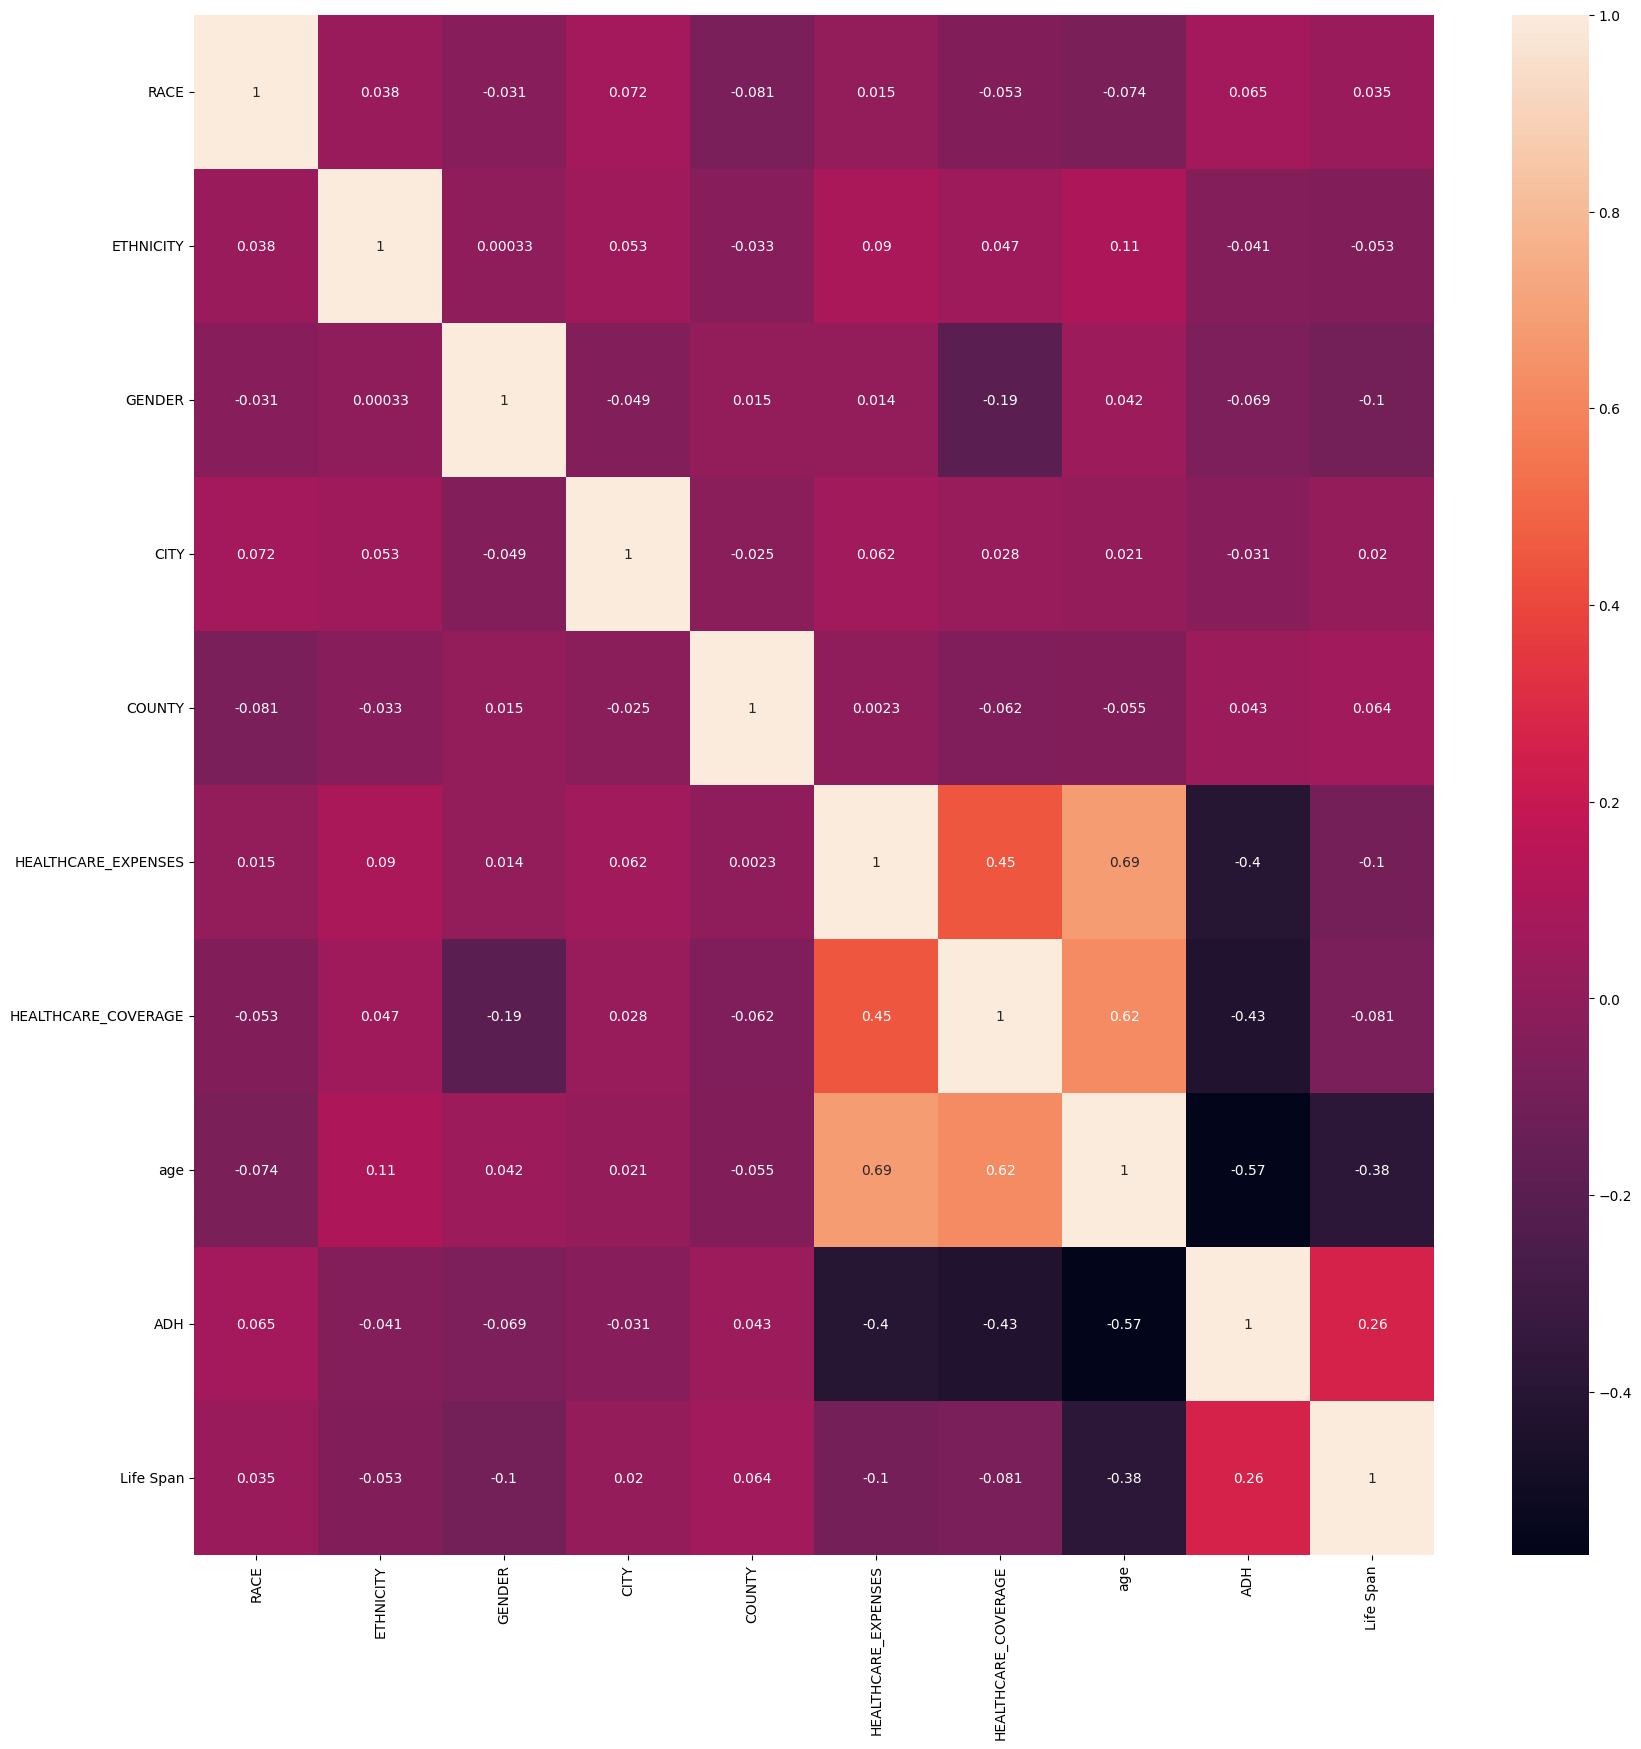

In [154]:
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

### probabilty plot

HEALTHCARE_EXPENSES


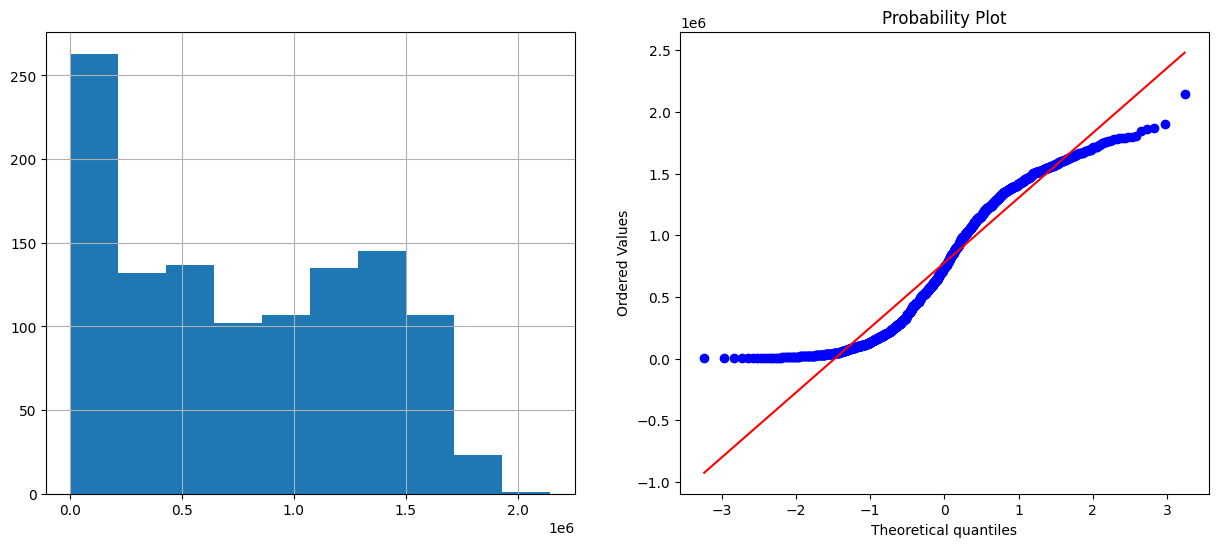

HEALTHCARE_COVERAGE


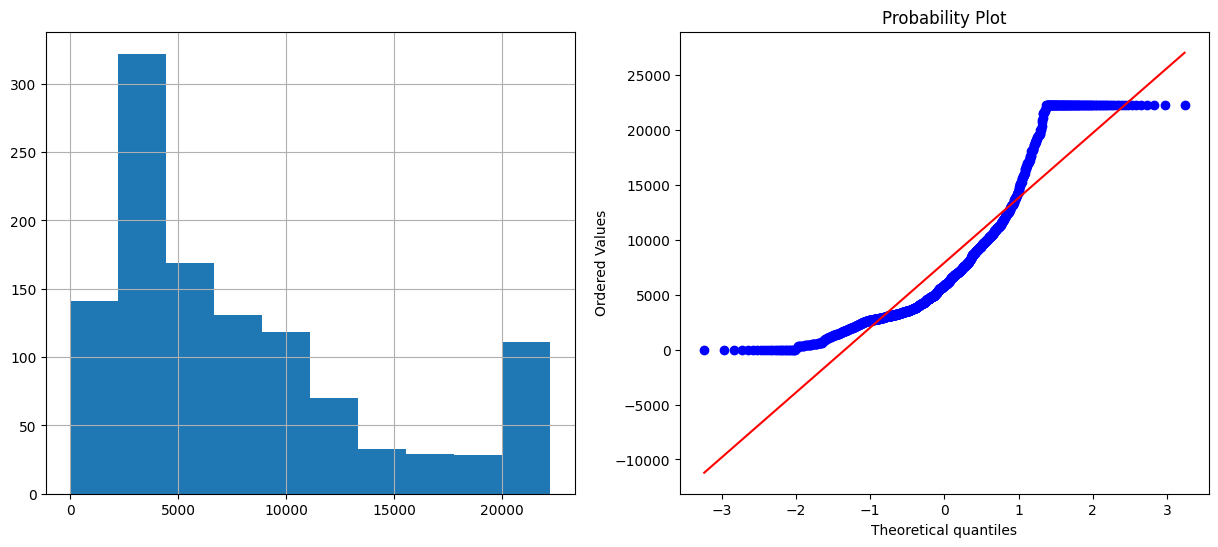

In [155]:
for feature in continuous_feature:
    print(feature)
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    data[feature].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(data[feature], dist="norm", plot=plt)
    plt.show()

### sampling target class

C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dty

<Axes: xlabel='ADH', ylabel='count'>

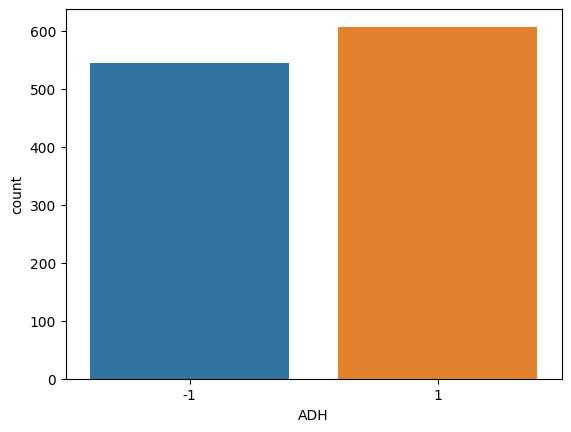

In [156]:
sns.countplot(data["ADH"])

### split data

In [157]:
from sklearn.model_selection import train_test_split

In [158]:
X = data.drop(["ADH"], axis=1)
Y = data["ADH"]

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size =0.2, stratify = Y, random_state = 0)

In [160]:
y_test

183     1
939    -1
654     1
1119    1
1075    1
       ..
533     1
786     1
1061   -1
800     1
117    -1
Name: ADH, Length: 231, dtype: int64

In [161]:
sm=SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_res)))

The number of classes before fit Counter({1: 485, -1: 436})
The number of classes after fit Counter({1: 485, -1: 485})


In [162]:
accuracylis=[]

### CatBoostClassifier

In [163]:
cat = CatBoostClassifier(iterations=2000, eval_metric = "AUC")
cat.fit(X_train_res, y_train_res)

Learning rate set to 0.005386
0:	total: 2.99ms	remaining: 5.98s
1:	total: 7.27ms	remaining: 7.27s
2:	total: 9.58ms	remaining: 6.38s
3:	total: 13.5ms	remaining: 6.72s
4:	total: 16.9ms	remaining: 6.74s
5:	total: 19.9ms	remaining: 6.6s
6:	total: 21.8ms	remaining: 6.21s
7:	total: 24.2ms	remaining: 6.02s
8:	total: 25.6ms	remaining: 5.66s
9:	total: 28ms	remaining: 5.57s
10:	total: 30.7ms	remaining: 5.54s
11:	total: 32.8ms	remaining: 5.43s
12:	total: 35.1ms	remaining: 5.37s
13:	total: 37.5ms	remaining: 5.32s
14:	total: 39.8ms	remaining: 5.26s
15:	total: 41.7ms	remaining: 5.17s
16:	total: 43.7ms	remaining: 5.1s
17:	total: 45.9ms	remaining: 5.05s
18:	total: 48.3ms	remaining: 5.03s
19:	total: 50.4ms	remaining: 4.99s
20:	total: 52.4ms	remaining: 4.94s
21:	total: 54.6ms	remaining: 4.91s
22:	total: 56.8ms	remaining: 4.88s
23:	total: 58.9ms	remaining: 4.85s
24:	total: 60.9ms	remaining: 4.81s
25:	total: 63.3ms	remaining: 4.8s
26:	total: 65.1ms	remaining: 4.76s
27:	total: 67.3ms	remaining: 4.74s
28:	t

279:	total: 614ms	remaining: 3.77s
280:	total: 616ms	remaining: 3.77s
281:	total: 619ms	remaining: 3.77s
282:	total: 621ms	remaining: 3.77s
283:	total: 623ms	remaining: 3.77s
284:	total: 626ms	remaining: 3.77s
285:	total: 628ms	remaining: 3.76s
286:	total: 630ms	remaining: 3.76s
287:	total: 633ms	remaining: 3.76s
288:	total: 635ms	remaining: 3.76s
289:	total: 637ms	remaining: 3.76s
290:	total: 640ms	remaining: 3.76s
291:	total: 642ms	remaining: 3.76s
292:	total: 645ms	remaining: 3.75s
293:	total: 648ms	remaining: 3.76s
294:	total: 650ms	remaining: 3.76s
295:	total: 654ms	remaining: 3.76s
296:	total: 658ms	remaining: 3.77s
297:	total: 661ms	remaining: 3.77s
298:	total: 663ms	remaining: 3.77s
299:	total: 665ms	remaining: 3.77s
300:	total: 668ms	remaining: 3.77s
301:	total: 670ms	remaining: 3.77s
302:	total: 672ms	remaining: 3.76s
303:	total: 674ms	remaining: 3.76s
304:	total: 676ms	remaining: 3.75s
305:	total: 677ms	remaining: 3.75s
306:	total: 679ms	remaining: 3.75s
307:	total: 681ms	re

549:	total: 1.2s	remaining: 3.18s
550:	total: 1.21s	remaining: 3.17s
551:	total: 1.21s	remaining: 3.17s
552:	total: 1.21s	remaining: 3.17s
553:	total: 1.21s	remaining: 3.17s
554:	total: 1.22s	remaining: 3.17s
555:	total: 1.22s	remaining: 3.17s
556:	total: 1.22s	remaining: 3.17s
557:	total: 1.22s	remaining: 3.16s
558:	total: 1.23s	remaining: 3.16s
559:	total: 1.23s	remaining: 3.16s
560:	total: 1.23s	remaining: 3.15s
561:	total: 1.23s	remaining: 3.15s
562:	total: 1.23s	remaining: 3.15s
563:	total: 1.24s	remaining: 3.15s
564:	total: 1.24s	remaining: 3.14s
565:	total: 1.24s	remaining: 3.14s
566:	total: 1.24s	remaining: 3.14s
567:	total: 1.24s	remaining: 3.13s
568:	total: 1.25s	remaining: 3.13s
569:	total: 1.25s	remaining: 3.13s
570:	total: 1.25s	remaining: 3.13s
571:	total: 1.25s	remaining: 3.13s
572:	total: 1.25s	remaining: 3.13s
573:	total: 1.26s	remaining: 3.12s
574:	total: 1.26s	remaining: 3.12s
575:	total: 1.26s	remaining: 3.12s
576:	total: 1.26s	remaining: 3.12s
577:	total: 1.27s	rem

818:	total: 1.79s	remaining: 2.59s
819:	total: 1.8s	remaining: 2.59s
820:	total: 1.8s	remaining: 2.58s
821:	total: 1.8s	remaining: 2.58s
822:	total: 1.8s	remaining: 2.58s
823:	total: 1.81s	remaining: 2.58s
824:	total: 1.81s	remaining: 2.58s
825:	total: 1.81s	remaining: 2.57s
826:	total: 1.81s	remaining: 2.57s
827:	total: 1.81s	remaining: 2.57s
828:	total: 1.81s	remaining: 2.56s
829:	total: 1.82s	remaining: 2.56s
830:	total: 1.82s	remaining: 2.56s
831:	total: 1.82s	remaining: 2.56s
832:	total: 1.82s	remaining: 2.56s
833:	total: 1.83s	remaining: 2.55s
834:	total: 1.83s	remaining: 2.55s
835:	total: 1.83s	remaining: 2.55s
836:	total: 1.83s	remaining: 2.55s
837:	total: 1.83s	remaining: 2.54s
838:	total: 1.84s	remaining: 2.54s
839:	total: 1.84s	remaining: 2.54s
840:	total: 1.84s	remaining: 2.54s
841:	total: 1.84s	remaining: 2.53s
842:	total: 1.84s	remaining: 2.53s
843:	total: 1.84s	remaining: 2.53s
844:	total: 1.85s	remaining: 2.52s
845:	total: 1.85s	remaining: 2.52s
846:	total: 1.85s	remain

1102:	total: 2.39s	remaining: 1.94s
1103:	total: 2.39s	remaining: 1.94s
1104:	total: 2.4s	remaining: 1.94s
1105:	total: 2.4s	remaining: 1.94s
1106:	total: 2.4s	remaining: 1.94s
1107:	total: 2.4s	remaining: 1.93s
1108:	total: 2.4s	remaining: 1.93s
1109:	total: 2.41s	remaining: 1.93s
1110:	total: 2.41s	remaining: 1.93s
1111:	total: 2.41s	remaining: 1.93s
1112:	total: 2.41s	remaining: 1.92s
1113:	total: 2.42s	remaining: 1.92s
1114:	total: 2.42s	remaining: 1.92s
1115:	total: 2.42s	remaining: 1.92s
1116:	total: 2.42s	remaining: 1.91s
1117:	total: 2.42s	remaining: 1.91s
1118:	total: 2.42s	remaining: 1.91s
1119:	total: 2.43s	remaining: 1.91s
1120:	total: 2.43s	remaining: 1.9s
1121:	total: 2.43s	remaining: 1.9s
1122:	total: 2.43s	remaining: 1.9s
1123:	total: 2.43s	remaining: 1.9s
1124:	total: 2.44s	remaining: 1.89s
1125:	total: 2.44s	remaining: 1.89s
1126:	total: 2.44s	remaining: 1.89s
1127:	total: 2.44s	remaining: 1.89s
1128:	total: 2.44s	remaining: 1.89s
1129:	total: 2.45s	remaining: 1.88s
1

1382:	total: 2.97s	remaining: 1.32s
1383:	total: 2.97s	remaining: 1.32s
1384:	total: 2.98s	remaining: 1.32s
1385:	total: 2.98s	remaining: 1.32s
1386:	total: 2.98s	remaining: 1.32s
1387:	total: 2.98s	remaining: 1.31s
1388:	total: 2.98s	remaining: 1.31s
1389:	total: 2.99s	remaining: 1.31s
1390:	total: 2.99s	remaining: 1.31s
1391:	total: 2.99s	remaining: 1.31s
1392:	total: 2.99s	remaining: 1.3s
1393:	total: 3s	remaining: 1.3s
1394:	total: 3s	remaining: 1.3s
1395:	total: 3s	remaining: 1.3s
1396:	total: 3s	remaining: 1.3s
1397:	total: 3s	remaining: 1.29s
1398:	total: 3.01s	remaining: 1.29s
1399:	total: 3.01s	remaining: 1.29s
1400:	total: 3.01s	remaining: 1.29s
1401:	total: 3.01s	remaining: 1.28s
1402:	total: 3.02s	remaining: 1.28s
1403:	total: 3.02s	remaining: 1.28s
1404:	total: 3.02s	remaining: 1.28s
1405:	total: 3.02s	remaining: 1.28s
1406:	total: 3.03s	remaining: 1.27s
1407:	total: 3.03s	remaining: 1.27s
1408:	total: 3.03s	remaining: 1.27s
1409:	total: 3.03s	remaining: 1.27s
1410:	total:

1670:	total: 3.56s	remaining: 702ms
1671:	total: 3.57s	remaining: 700ms
1672:	total: 3.57s	remaining: 698ms
1673:	total: 3.57s	remaining: 696ms
1674:	total: 3.57s	remaining: 694ms
1675:	total: 3.58s	remaining: 691ms
1676:	total: 3.58s	remaining: 689ms
1677:	total: 3.58s	remaining: 687ms
1678:	total: 3.58s	remaining: 685ms
1679:	total: 3.59s	remaining: 683ms
1680:	total: 3.59s	remaining: 681ms
1681:	total: 3.59s	remaining: 679ms
1682:	total: 3.59s	remaining: 677ms
1683:	total: 3.59s	remaining: 674ms
1684:	total: 3.6s	remaining: 672ms
1685:	total: 3.6s	remaining: 670ms
1686:	total: 3.6s	remaining: 668ms
1687:	total: 3.6s	remaining: 666ms
1688:	total: 3.6s	remaining: 664ms
1689:	total: 3.61s	remaining: 661ms
1690:	total: 3.61s	remaining: 659ms
1691:	total: 3.61s	remaining: 657ms
1692:	total: 3.61s	remaining: 655ms
1693:	total: 3.61s	remaining: 653ms
1694:	total: 3.62s	remaining: 651ms
1695:	total: 3.62s	remaining: 648ms
1696:	total: 3.62s	remaining: 646ms
1697:	total: 3.62s	remaining: 644

1956:	total: 4.16s	remaining: 91.4ms
1957:	total: 4.16s	remaining: 89.2ms
1958:	total: 4.16s	remaining: 87.1ms
1959:	total: 4.16s	remaining: 85ms
1960:	total: 4.17s	remaining: 82.9ms
1961:	total: 4.17s	remaining: 80.7ms
1962:	total: 4.17s	remaining: 78.6ms
1963:	total: 4.17s	remaining: 76.5ms
1964:	total: 4.17s	remaining: 74.3ms
1965:	total: 4.18s	remaining: 72.2ms
1966:	total: 4.18s	remaining: 70.1ms
1967:	total: 4.18s	remaining: 68ms
1968:	total: 4.18s	remaining: 65.9ms
1969:	total: 4.18s	remaining: 63.7ms
1970:	total: 4.19s	remaining: 61.6ms
1971:	total: 4.19s	remaining: 59.5ms
1972:	total: 4.19s	remaining: 57.4ms
1973:	total: 4.19s	remaining: 55.2ms
1974:	total: 4.2s	remaining: 53.1ms
1975:	total: 4.2s	remaining: 51ms
1976:	total: 4.2s	remaining: 48.9ms
1977:	total: 4.2s	remaining: 46.7ms
1978:	total: 4.2s	remaining: 44.6ms
1979:	total: 4.21s	remaining: 42.5ms
1980:	total: 4.21s	remaining: 40.4ms
1981:	total: 4.21s	remaining: 38.2ms
1982:	total: 4.21s	remaining: 36.1ms
1983:	total:

In [164]:
y_pred = cat.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
accuracylis.append(accuracy_score(y_test,y_pred))

[[83 26]
 [26 96]]
0.7748917748917749
              precision    recall  f1-score   support

          -1       0.76      0.76      0.76       109
           1       0.79      0.79      0.79       122

    accuracy                           0.77       231
   macro avg       0.77      0.77      0.77       231
weighted avg       0.77      0.77      0.77       231



### RandomForestClassifier

In [165]:
rf=RandomForestClassifier()
rf.fit(X_train_res,y_train_res)

RandomForestClassifier()

In [166]:
y_pred1 = rf.predict(X_test)
print(confusion_matrix(y_test,y_pred1))
print(accuracy_score(y_test,y_pred1))
print(classification_report(y_test,y_pred1))
accuracylis.append(accuracy_score(y_test,y_pred1))

[[82 27]
 [29 93]]
0.7575757575757576
              precision    recall  f1-score   support

          -1       0.74      0.75      0.75       109
           1       0.78      0.76      0.77       122

    accuracy                           0.76       231
   macro avg       0.76      0.76      0.76       231
weighted avg       0.76      0.76      0.76       231



### Logisticregression

In [167]:
logreg = LogisticRegression()
logreg.fit(X_train_res, y_train_res)

LogisticRegression()

In [168]:
y_pred2 = logreg.predict(X_test)
print(confusion_matrix(y_test,y_pred2))
print(accuracy_score(y_test,y_pred2))
print(classification_report(y_test,y_pred2))
accuracylis.append(accuracy_score(y_test,y_pred2))

[[93 16]
 [60 62]]
0.670995670995671
              precision    recall  f1-score   support

          -1       0.61      0.85      0.71       109
           1       0.79      0.51      0.62       122

    accuracy                           0.67       231
   macro avg       0.70      0.68      0.66       231
weighted avg       0.71      0.67      0.66       231



### GaussianNB

In [169]:
gnb = GaussianNB()
gnb.fit(X_train_res, y_train_res)

GaussianNB()

In [170]:
y_pred3 = gnb.predict(X_test)
print(confusion_matrix(y_test,y_pred3))
print(accuracy_score(y_test,y_pred3))
print(classification_report(y_test,y_pred3))
accuracylis.append(accuracy_score(y_test,y_pred3))

[[75 34]
 [23 99]]
0.7532467532467533
              precision    recall  f1-score   support

          -1       0.77      0.69      0.72       109
           1       0.74      0.81      0.78       122

    accuracy                           0.75       231
   macro avg       0.75      0.75      0.75       231
weighted avg       0.75      0.75      0.75       231



### KNeighborsClassifier

In [171]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_res, y_train_res)

KNeighborsClassifier(n_neighbors=3)

In [172]:
y_pred4 = knn.predict(X_test)
print(confusion_matrix(y_test,y_pred4))
print(accuracy_score(y_test,y_pred4))
print(classification_report(y_test,y_pred4))
accuracylis.append(accuracy_score(y_test,y_pred4))

[[70 39]
 [32 90]]
0.6926406926406926
              precision    recall  f1-score   support

          -1       0.69      0.64      0.66       109
           1       0.70      0.74      0.72       122

    accuracy                           0.69       231
   macro avg       0.69      0.69      0.69       231
weighted avg       0.69      0.69      0.69       231



### Model Comparision

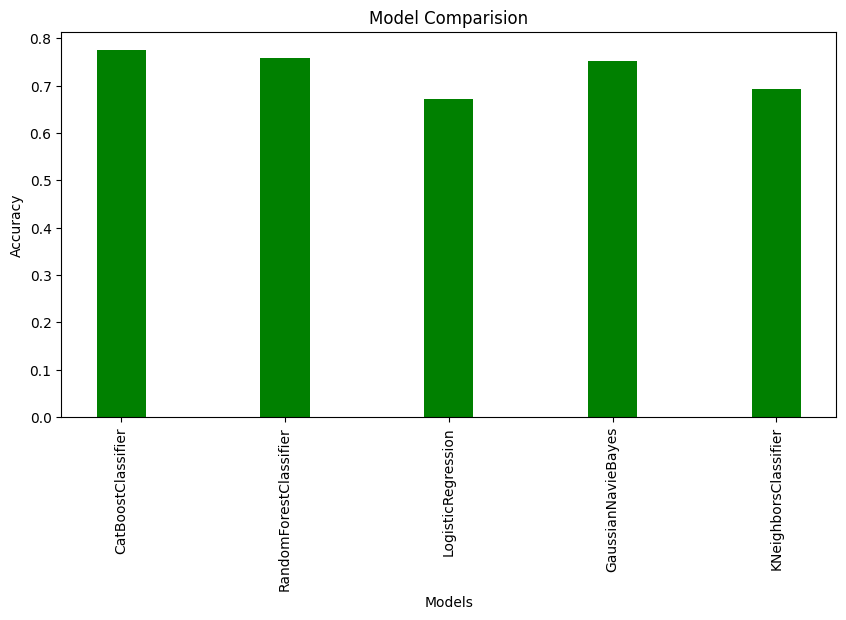

In [173]:
models=['CatBoostClassifier','RandomForestClassifier','LogisticRegression','GaussianNavieBayes','KNeighborsClassifier']
fig=plt.figure(figsize=(10,5))
plt.bar(models,accuracylis,color='g',width=0.3)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparision')
plt.xticks(rotation=90)
plt.show()

In [174]:
print(accuracylis)

[0.7748917748917749, 0.7575757575757576, 0.670995670995671, 0.7532467532467533, 0.6926406926406926]


### Interpretations

### Relationship between RACE and ADH

C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(v

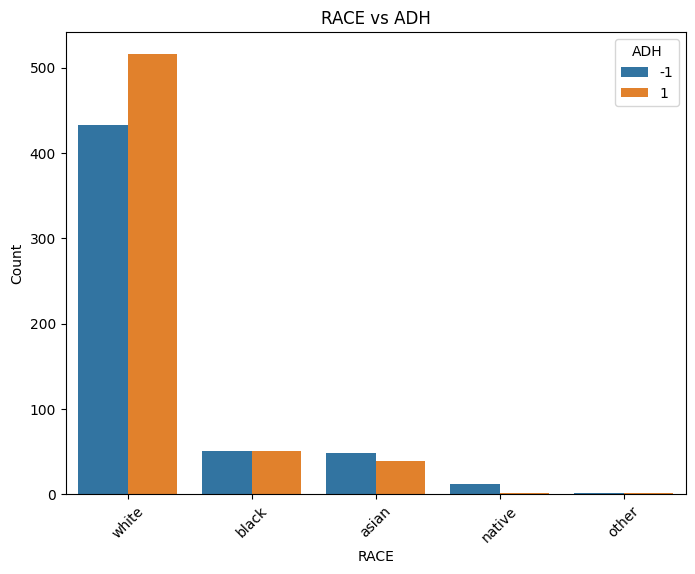

In [180]:
import matplotlib.pyplot as plt
import seaborn as sns

# Provided mappings
race_mapping = {'asian': 0, 'black': 1, 'native': 2, 'other': 3, 'white': 4}

# Inverse the mapping for 'RACE' column
data['RACE'] = data['RACE'].map({v: k for k, v in race_mapping.items()})

# Plotting 'RACE' vs 'ADH' using the mapped categorical values
plt.figure(figsize=(8, 6))
sns.countplot(x='RACE', hue='ADH', data=data)
plt.title('RACE vs ADH')
plt.xlabel('RACE')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.show()


##### from the plot we can say that white people has high adherence and and native people had less adherence

### Ethinicity vs ADH

C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


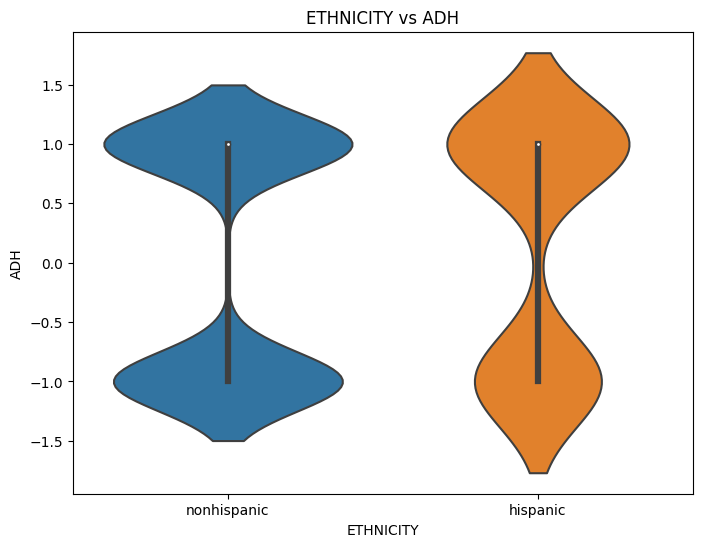

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns

# Provided mappings
ethnicity_mapping = {'hispanic': 0, 'nonhispanic': 1}

# Inverse the mapping for 'ETHNICITY' column
data['ETHNICITY'] = data['ETHNICITY'].map({v: k for k, v in ethnicity_mapping.items()})

# Plotting 'ETHNICITY' vs 'ADH' using the mapped categorical values
plt.figure(figsize=(8, 6))
sns.violinplot(x='ETHNICITY', y='ADH', data=data)
plt.title('ETHNICITY vs ADH')
plt.xlabel('ETHNICITY')
plt.ylabel('ADH')
plt.show()


#### from the plot we can say that for nonhispanic and non hispanic people there is high chance adherence and for hispanic people it was comparitvely low compared to nonhispanic 

### Gender vs ADH

C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(v

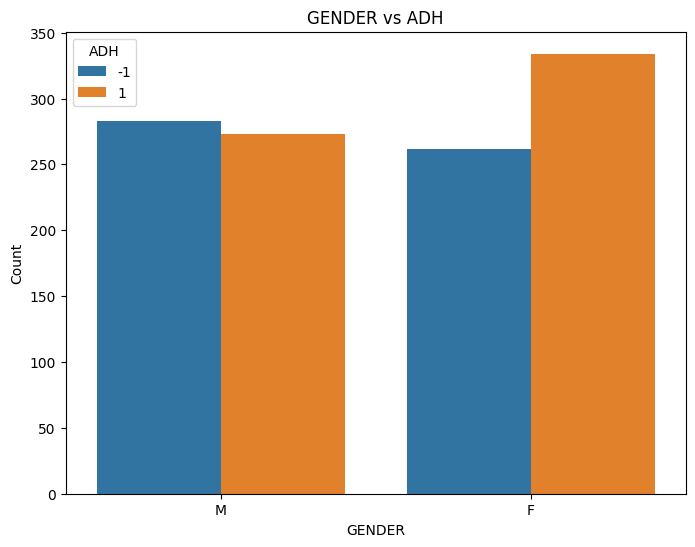

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns

# Provided mappings
gender_mapping = {'F': 0, 'M': 1}

# Inverse the mapping for 'GENDER' column
data['GENDER'] = data['GENDER'].map({v: k for k, v in gender_mapping.items()})

# Plotting 'GENDER' vs 'ADH' using the mapped categorical values
plt.figure(figsize=(8, 6))
sns.countplot(x='GENDER', hue='ADH', data=data)
plt.title('GENDER vs ADH')
plt.xlabel('GENDER')
plt.ylabel('Count')
plt.show()


#### for male there is not much difference between adherence and non adherence and for females there is significant difference between adherence and non adherence , where there is high chances of adherence in female than in male

### 3D plot for HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,ADH

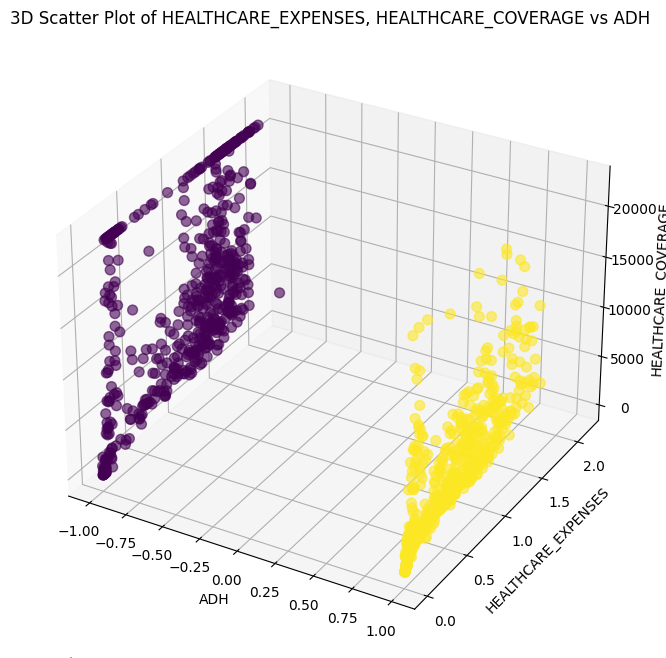

In [200]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'data' contains necessary columns ('ADH', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data['ADH'], data['HEALTHCARE_EXPENSES'], data['HEALTHCARE_COVERAGE'], c=data['ADH'], cmap='viridis', s=50, alpha=0.6)
ax.set_xlabel('ADH')
ax.set_ylabel('HEALTHCARE_EXPENSES')
ax.set_zlabel('HEALTHCARE_COVERAGE')
ax.set_title('3D Scatter Plot of HEALTHCARE_EXPENSES, HEALTHCARE_COVERAGE vs ADH')
plt.show()


#### for adherence we can see more density in low health coverage and for adherence we see more density in high health expenses

### Recomendations


1. Native Population Engagement: Collaborate with indigenous community leaders to design culturally sensitive adherence programs, incorporating traditional practices to improve medication adherence among native populations.

2. Hispanic Community Outreach: Develop targeted educational campaigns in Spanish, emphasizing the importance of medication adherence, while leveraging community influencers to increase trust and engagement within Hispanic communities.

3. Male-Centric Support: Create tailored interventions aimed at addressing specific barriers to adherence among males, such as providing discreet medication management solutions or targeted educational materials emphasizing the benefits of adherence for men's health.

4. Health Coverage Alignment for Adherence: Work with insurers to develop incentives tied to adherence, such as reduced copays for consistently adherent customers, aligning health coverage benefits with medication adherence for improved outcomes.

5. Data-Informed Health Expense Strategies: Analyze high health expense patterns to identify potential barriers to adherence, offering cost-effective solutions like mail-order prescriptions or co-payment assistance to mitigate financial obstacles.